# This Notebook aims at solving a simple Route Optimization (below) using Google OR Tools 
### (Solved using guidance from a Udemy Resource "Optimization with Python")

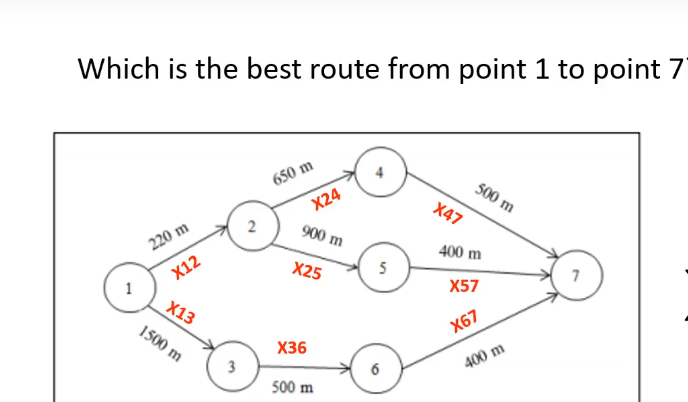

# 1. Importing necessary packages

In [1]:
import pandas as pd
from ortools.sat.python import cp_model
import numpy as np

# 2. Defining node inputs and combinations of paths

### First we need to create a Node Index and the respective route charateristic (Origin, Middle node, destination)
### Second, we need to create a combination of "from" and "to" nodes and their respective distance as shown above

In [2]:
node_idx = {
    'node_idx': [1, 2, 3, 4, 5, 6, 7],
    'node_desc': [
        'Origin', 'Middle_Node', 'Middle_Node', 'Middle_Node', 'Middle_Node',
        'Middle_Node', 'Destination'
    ]
}

In [3]:
df_node = pd.DataFrame(node_idx)

In [4]:
# Created the dictionary of Node index and it's descritpion and then passed into the Pandas Dataframe
df_node

,node_idx,node_desc
0,1,Origin
1,2,Middle_Node
2,3,Middle_Node
3,4,Middle_Node
4,5,Middle_Node
5,6,Middle_Node
6,7,Destination


In [5]:
# Creating a "From" and "To" Node combination.
# This is manually created, but for larger problems, we can use Itertools combinations to create the route combinations

route_dict = {
    'from': [1, 1, 2, 2, 4, 5, 3, 6],
    'to': [2, 3, 4, 5, 7, 7, 6, 7],
    'distance': [220, 1500, 650, 900, 500, 400, 500, 400]
}

In [6]:
df_route = pd.DataFrame(route_dict)

In [7]:
df_route

,from,to,distance
0,1,2,220
1,1,3,1500
2,2,4,650
3,2,5,900
4,4,7,500
5,5,7,400
6,3,6,500
7,6,7,400


In [8]:
# Creating a 0 valued list equal to the size of the df_route. This will be 1 if the LP model chose this route

x = np.zeros(len(df_route)).tolist()

In [9]:
x

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# 3. Instantiating LP (CP) model and creating Objective functions, Constraints

In [10]:
model = cp_model.CpModel()

In [11]:
# Creating Variables based on the df_route Index. 
# Binary Variable will be defined so to let the model choose a route (1) and drop a route (o)

for i in df_route.index:
    x[i] = model.NewIntVar(0,1,'x[{}]'.format([i]))

In [12]:
x

[x[[0]](0..1),
 x[[1]](0..1),
 x[[2]](0..1),
 x[[3]](0..1),
 x[[4]](0..1),
 x[[5]](0..1),
 x[[6]](0..1),
 x[[7]](0..1)]

In [13]:
# Objective function defintion and passing to the model

obj_func = sum([x[i]*df_route.distance[i] for i in df_route.index])

In [14]:
print(obj_func)

((((((((220 * x[[0]]) + (1500 * x[[1]])) + (650 * x[[2]])) + (900 * x[[3]])) + (500 * x[[4]])) + (400 * x[[5]])) + (500 * x[[6]])) + (400 * x[[7]]))


In [15]:
# Passing the function to CP Model
model.Minimize(obj_func)

In [16]:
# Constraint defintion
origin_node = int(df_node[df_node['node_desc']=='Origin']['node_idx'])
dest_node = int(df_node[df_node['node_desc']=='Destination']['node_idx'])

In [17]:
origin_node,dest_node

(1, 7)

In [18]:
# Below function simply means the model should select only one Origin combination and one Destination combination
# In this example(picture from top), one from x12 or x13 should be origin, one from x47,x57,x67 should be destination

origin_constraint = [x[i] for i in df_route.index[df_route['from']==origin_node]]
dest_constraint = [x[i] for i in df_route.index[df_route['to']==dest_node]]

In [19]:
model.Add(sum(origin_constraint) == 1)
model.Add(sum(dest_constraint) == 1)

In [20]:
# Creating a constraint that defines that any Inbound to a particular Node should also have a Outbound so it forms a Flow
# Syntactically we need to make sure the Indexes of df_route of columns "to" and "from" should be equal

for i in df_node[df_node['node_desc']=='Middle_Node']['node_idx']:
    sum_inbound = sum([x[j] for j in df_route.index[df_route['to']==i]])
    sum_outbound = sum([x[k] for k in df_route.index[df_route['from']==i]])
    print(sum_inbound,i)
    print(sum_outbound,i)
    model.Add(sum_inbound==sum_outbound)

x[[0]] 2
(x[[2]] + x[[3]]) 2
x[[1]] 3
x[[6]] 3
x[[2]] 4
x[[4]] 4
x[[3]] 5
x[[5]] 5
x[[6]] 6
x[[7]] 6


In [21]:
# passing this Model defined to model solver

solver = cp_model.CpSolver()
solution = solver.Solve(model)

In [22]:
solver.ObjectiveValue()

1370.0

In [23]:
solver.StatusName(solution)

'OPTIMAL'

In [25]:
# Creating a column that shows Activated nodes and distance Minimization
df_route['Activated_Route'] = 0

In [28]:
for p in df_route.index:
    df_route['Activated_Route'][p] = solver.Value(x[p])

In [29]:
df_route

,from,to,distance,Activated_Route
0,1,2,220,1
1,1,3,1500,0
2,2,4,650,1
3,2,5,900,0
4,4,7,500,1
5,5,7,400,0
6,3,6,500,0
7,6,7,400,0


# Final Solution

## i) Route Selected =  1-2-4-7
## ii) Minimum Distance = 1370